# Analysis of AirBNB data from Boston
In this analysis, Boston AirBNB data from the listings.csv file downloaded from https://www.kaggle.com/airbnb/boston/data is analyzed according to the CRISP-DM process to answer some questions, mainly relevant for people offereing their accommendations.

## 1. Business understanding
AirBNB is a community based platform in which users can offer their private accommendations to other people. So the platform acts as a kind of broker. Users can earn money by renting their couch, their room, their flats or even a complete houses. Its is assumed that one reason to book a specific accommendation is - beside location, price, and amenities - the rating by other users. Here is shall be analyzed whether there are aspects that users can influence that are corrolated with a high rating.

The following aspects are analyzed in 4. Modelling:
1. Is there a relation between price and ratings?
2. Is there a relation between neighborhoods and ratings and price?
3. Is there a relation between the number of reviews and the rating? In other words: Is the distribution of ratings skewed?
4. Is there a relation between amenities and rating?
5. Is there a way to predict the rating based on the set of information?

Some questions can be answered by directly looking into the dataset. Of course, it is expected that the overall experience during the stay at a location is the most crucial point for the rating. Nevertheless, it is checked here whether the the questions above indicate also other aspects.

## 2. Data understanding
The data is loaded and a number of things are checked to understand the dataset.

In [52]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

df = pd.read_csv('./listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


### Determine the number of rows (entries for specifc accommendations) and columns (different features of the accommendations)

In [2]:
num_rows = df.shape[0] #Contains the number of rows in the dataset
num_cols = df.shape[1] #Contains the number of columns in the dataset

print('The dataset contains', num_rows, 'rows and', num_cols, 'columns.')

The dataset contains 3585 rows and 95 columns.


### Check of the columns to find out which are important for this analysis and check their status
The dataset contains many full text columns. They will not be considered here. It is assumed that neighborhood (the cleansed version), the property type, the room type, the accommodates, the bed type, the amenities, the price, the availability, the number of reviews, and of course the rating score itself play a role to answer the business questions above.

In [3]:
no_nulls = set(df.columns[df.isnull().mean()==0])
print(no_nulls)

{'scrape_id', 'host_name', 'bed_type', 'country', 'extra_people', 'name', 'host_is_superhost', 'availability_90', 'room_type', 'picture_url', 'description', 'availability_30', 'id', 'require_guest_profile_picture', 'street', 'host_thumbnail_url', 'guests_included', 'host_picture_url', 'host_total_listings_count', 'price', 'host_verifications', 'minimum_nights', 'availability_60', 'availability_365', 'host_identity_verified', 'smart_location', 'amenities', 'state', 'listing_url', 'host_id', 'host_has_profile_pic', 'experiences_offered', 'accommodates', 'cancellation_policy', 'host_url', 'maximum_nights', 'calculated_host_listings_count', 'host_listings_count', 'calendar_last_scraped', 'last_scraped', 'requires_license', 'calendar_updated', 'neighbourhood_cleansed', 'longitude', 'number_of_reviews', 'is_location_exact', 'country_code', 'instant_bookable', 'require_guest_phone_verification', 'latitude', 'host_since'}


In [4]:
most_missing_cols = set(df.columns[df.isnull().mean() > 0.5])
print(most_missing_cols)

{'square_feet', 'security_deposit', 'weekly_price', 'neighbourhood_group_cleansed', 'has_availability', 'license', 'jurisdiction_names', 'notes', 'monthly_price'}


In [5]:
neighbourhood=df['neighbourhood_cleansed'].value_counts()
print(neighbourhood)

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64


In [6]:
property_type=df['property_type'].value_counts()
print(property_type)

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64


In [7]:
room_type=df['room_type'].value_counts()
print(room_type)

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64


In [8]:
bed_type=df['bed_type'].value_counts()
print(bed_type)

Real Bed         3453
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64


### Check the different amenties which are unfortunately not listed in specific columns: To this end, the code from "Lession 1" has been adapted to generate a plot showing the fraction of each amenty.

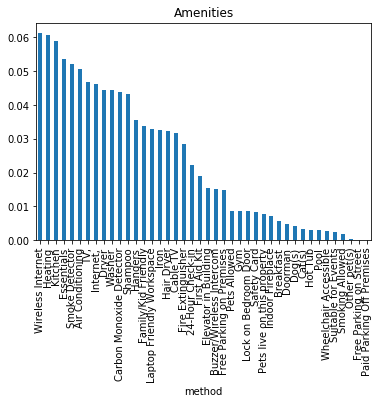

In [9]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of different types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

possible_vals = ["24-Hour Check-in", "Air Conditioning", "Breakfast", "Buzzer/Wireless Intercom", 
                 "Cable TV", "Carbon Monoxide Detector", "Cat(s)", "Dog(s)", "Doorman", ",Dryer",
                 "Elevator in Building", "Essentials", "Family/Kid Friendly", "Fire Extinguisher",
                 "First Aid Kit", "Free Parking on Premises", "Free Parking on Street", "Gym", "Hangers",
                 "Hair Dryer", "Heating", "Hot Tub", "Indoor Fireplace", "Internet,", "Iron", "Kitchen",
                 "Laptop Friendly Workspace", "Lock on Bedroom Door", "Other pet(s)", "Paid Parking Off Premises",
                 "Pets Allowed", "Pets live on this property", "Pool", "Safety Card", "Shampoo", "Smoke Detector",
                 "Smoking Allowed", "Suitable for Events", "TV,", "Washer", "Wheelchair Accessible",
                 "Wireless Internet"]

def clean_and_plot(df, title='Amenities', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['amenities'].value_counts().reset_index()
    study.rename(columns={'index': 'method', 'amenities': 'count'}, inplace=True)
    study_df = total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df)

### Check the relation between between higher availablity and number of ratings
The idea is is that highly frequented accommendations get more ratings.
At first it is checked wether the columns are complete and contain no NaNs.

In [12]:
print(df["availability_30"].isnull().value_counts())
print(df["availability_60"].isnull().value_counts())
print(df["availability_90"].isnull().value_counts())
print(df["availability_365"].isnull().value_counts())
print(df["number_of_reviews"].isnull().value_counts())

False    3585
Name: availability_30, dtype: int64
False    3585
Name: availability_60, dtype: int64
False    3585
Name: availability_90, dtype: int64
False    3585
Name: availability_365, dtype: int64
False    3585
Name: number_of_reviews, dtype: int64


The columns are complete. The correlation coefficients are calculated and corresponding scatter plots are generated to check whether there is some correlation between these the measures.

Pearson correlation coefficient:
-0.07130776388476068


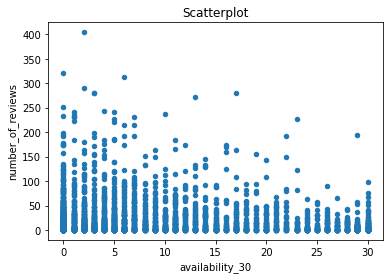

In [13]:
df.plot.scatter(x='availability_30', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_30'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
-0.03216877702196826


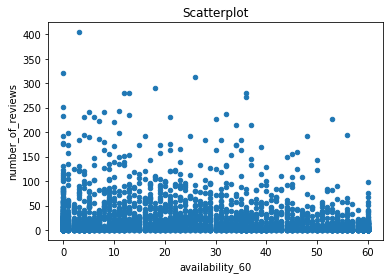

In [14]:
df.plot.scatter(x='availability_60', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_60'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
0.022165564937379412


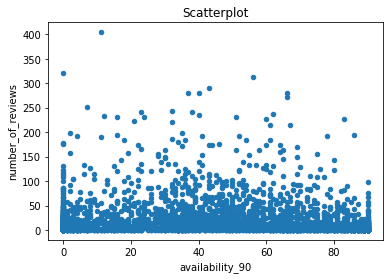

In [15]:
df.plot.scatter(x='availability_90', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_90'].corr(df['number_of_reviews']))

Pearson correlation coefficient:
0.19228916562365242


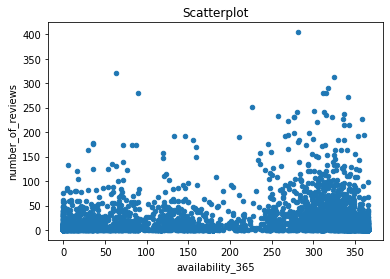

In [16]:
df.plot.scatter(x='availability_365', y='number_of_reviews')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df['availability_365'].corr(df['number_of_reviews']))

No consistent correlation is visible. Thus, the availablity is not considered in the further analysis steps.

## 3. Data preparation

In [17]:
df_prepared = df.copy() # Copy the original dataset into a new dataframe which is then step-by-step changed

### Correction of the price column
The price column contains unfortunately no number values but strings due to a leading "$" symbol and commas as 1000-seperators. Furthermore, the two decimal digits are always "0" and are, therefore, useless. Thus, these things are removed and the price is converted to int values. After that, the price distribution is plotted.

In [18]:
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[1:])) # Remove leading "$"
df_prepared['price'] = df_prepared['price'].map(lambda i: (i[:-3])) # Remove decimal values (last 3 characters)
df_prepared['price'] = df_prepared['price'].map(lambda i: int(i.replace(",", ""))) # Remove commas and convert to int

Text(0, 0.5, 'Frequency')

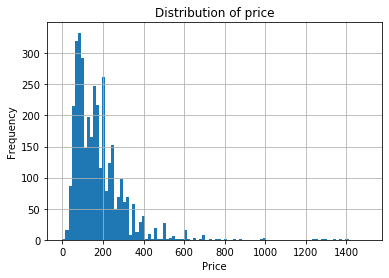

In [19]:
df_prepared['price'].hist(bins=100, range=(0, 1500))
plt.title("Distribution of price")
plt.xlabel('Price')
plt.ylabel('Frequency')

### Replacement of the amenities column by specific columns for each amenity
The amenities column is tricky, since it contains strings of all types of combinations of amenities. This is replaced by specific columns with boolean values.

In [20]:
df_prepared['24HourCheckin']          =df_prepared['amenities'].map(lambda i: "24-Hour Check-in" in i)
df_prepared['airConditioning']        =df_prepared['amenities'].map(lambda i: "Air Conditioning" in i)
df_prepared['breakfast']              =df_prepared['amenities'].map(lambda i: "Breakfast" in i)
df_prepared['buzzerWirelessIntercom'] =df_prepared['amenities'].map(lambda i: "Buzzer/Wireless Intercom" in i)
df_prepared['cableTV']                =df_prepared['amenities'].map(lambda i: "Cable TV" in i)
df_prepared['carbonMonoxideDetector'] =df_prepared['amenities'].map(lambda i: "Carbon Monoxide Detector" in i)
df_prepared['cats']                   =df_prepared['amenities'].map(lambda i: "Cat(s)" in i)
df_prepared['dogs']                   =df_prepared['amenities'].map(lambda i: "Dog(s)" in i)
df_prepared['doorman']                =df_prepared['amenities'].map(lambda i: "Doorman" in i)
df_prepared['dryer']                  =df_prepared['amenities'].map(lambda i: ",Dryer" in i) # Prohibits match in "Hair Dryer"
df_prepared['elevatorInBuilding']     =df_prepared['amenities'].map(lambda i: "Elevator in Building" in i)
df_prepared['essentials']             =df_prepared['amenities'].map(lambda i: "Essentials" in i)
df_prepared['familyKidFriendly']      =df_prepared['amenities'].map(lambda i: "Family/Kid Friendly" in i)
df_prepared['fireExtinguisher']       =df_prepared['amenities'].map(lambda i: "Fire Extinguisher" in i)
df_prepared['firstAidKit']            =df_prepared['amenities'].map(lambda i: "First Aid Kit" in i)
df_prepared['freeParkingOnPremises']  =df_prepared['amenities'].map(lambda i: "Free Parking on Premises" in i)
df_prepared['freeParkingOnStreet']    =df_prepared['amenities'].map(lambda i: "Free Parking on Street" in i)
df_prepared['gym']                    =df_prepared['amenities'].map(lambda i: "Gym" in i)
df_prepared['hangers']                =df_prepared['amenities'].map(lambda i: "Hangers" in i)
df_prepared['hairDryer']              =df_prepared['amenities'].map(lambda i: "Hair Dryer" in i)
df_prepared['heating']                =df_prepared['amenities'].map(lambda i: "Heating" in i)
df_prepared['hotTub']                 =df_prepared['amenities'].map(lambda i: "Hot Tub" in i)
df_prepared['indoorFireplace']        =df_prepared['amenities'].map(lambda i: "Indoor Fireplace" in i)
df_prepared['internet']               =df_prepared['amenities'].map(lambda i: "Internet," in i) # Prohibits match in "Cable TV"
df_prepared['iron']                   =df_prepared['amenities'].map(lambda i: "Iron" in i)
df_prepared['kitchen']                =df_prepared['amenities'].map(lambda i: "Kitchen" in i)
df_prepared['laptopFriendlyWorkspace']=df_prepared['amenities'].map(lambda i: "Laptop Friendly Workspace" in i)
df_prepared['lockOnBedroomDoor']      =df_prepared['amenities'].map(lambda i: "Lock on Bedroom Door" in i)
df_prepared['otherPets']              =df_prepared['amenities'].map(lambda i: "Other pet(s)" in i)
df_prepared['paidParkingOffPremises'] =df_prepared['amenities'].map(lambda i: "Paid Parking Off Premises" in i)
df_prepared['petsAllowed']            =df_prepared['amenities'].map(lambda i: "Pets Allowed" in i)
df_prepared['petsLiveOnThisProperty'] =df_prepared['amenities'].map(lambda i: "Pets live on this property" in i)
df_prepared['pool']                   =df_prepared['amenities'].map(lambda i: "Pool" in i)
df_prepared['safetyCard']             =df_prepared['amenities'].map(lambda i: "Safety Card" in i)
df_prepared['shampoo']                =df_prepared['amenities'].map(lambda i: "Shampoo" in i)
df_prepared['smokeDetector']          =df_prepared['amenities'].map(lambda i: "Smoke Detector" in i)
df_prepared['smokingAllowed']         =df_prepared['amenities'].map(lambda i: "Smoking Allowed" in i)
df_prepared['suitableForEvents']      =df_prepared['amenities'].map(lambda i: "Suitable for Events" in i)
df_prepared['tV']                     =df_prepared['amenities'].map(lambda i: "TV," in i) # Prohibits match in "Cable TV"
df_prepared['washer']                 =df_prepared['amenities'].map(lambda i: "Washer" in i)
df_prepared['wheelchairAccessible']   =df_prepared['amenities'].map(lambda i: "Wheelchair Accessible" in i)
df_prepared['wirelessInternet']       =df_prepared['amenities'].map(lambda i: "Wireless Internet" in i)

del df_prepared['amenities']


In [21]:
df_prepared.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,pool,safetyCard,shampoo,smokeDetector,smokingAllowed,suitableForEvents,tV,washer,wheelchairAccessible,wirelessInternet
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,False,False,True,True,False,False,True,True,False,True
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,False,False,True,True,False,False,True,True,False,True
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,False,True,True,True,False,False,True,True,False,True
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,False,True,True,True,False,False,True,True,False,True
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,False,False,True,True,False,False,False,False,False,True


### Removing or impeding rows

In [123]:
print(df_prepared["review_scores_rating"].isnull().value_counts())

False    2772
True      813
Name: review_scores_rating, dtype: int64


29% of the review scores ratings contain no value, since the corresponding accommendations got no review yet. Since the goal is to predict this column later on, the missing rows will be removed.

In [23]:
df_reduced=df_prepared.dropna(subset=['review_scores_rating'], axis=0)

# 4. Modelling

### Is there a relation between price and ratings?

Pearson correlation coefficient:
0.1056505948227876


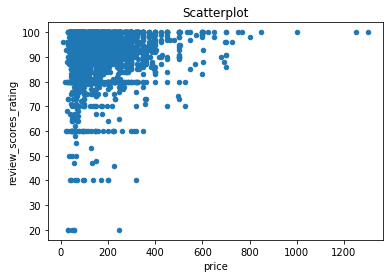

In [24]:
df_reduced.plot.scatter(x='price', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_reduced['price'].corr(df_reduced['review_scores_rating']))

There seems to be a slight correleation between price and rating. The higher the price, the higher is the rating. In higher price region, there are no real bad ratings.

### Is there a relation between neighborhoods and scores ratings and price?

In [49]:
df_neighbourhood_relations=pd.DataFrame()
df_neighbourhood_relations['review_scores_rating']=df_reduced.groupby('neighbourhood_cleansed').mean()['review_scores_rating'].sort_values(ascending=False)
df_neighbourhood_relations['price']=df_reduced.groupby('neighbourhood_cleansed').mean()['price'].sort_values(ascending=False)
df_neighbourhood_relations.head()

,review_scores_rating,price
neighbourhood_cleansed,,
Leather District,98.333333,242.666667
Roslindale,95.380000,95.460000
West Roxbury,95.212121,96.484848
South Boston Waterfront,94.431034,263.810345
Jamaica Plain,94.159322,136.288136


Pearson correlation coefficient:
0.31766590732863437


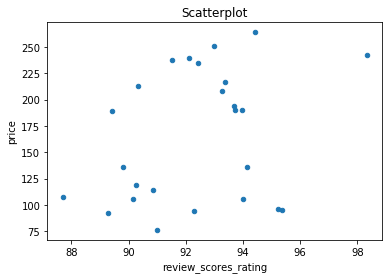

In [50]:
df_neighbourhood_relations.plot.scatter(x='review_scores_rating', y='price')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_neighbourhood_relations['review_scores_rating'].corr(df_neighbourhood_relations['price']))

It is not analyzed in more details here, but it seems that neighbourhoods with a higher rating also have a higher mean price and vice versa. Of course, the correlation is weak since a lot of people might decide to stay in a specific neighborhood for specific reasons not covered here and other might be completely happy with a lower standards accommendation.

### Is there a relation between the number of reviews and the scores rating? In other words: Is the distribution of ratings skewed?

Pearson correlation coefficient:
0.02277785222784338


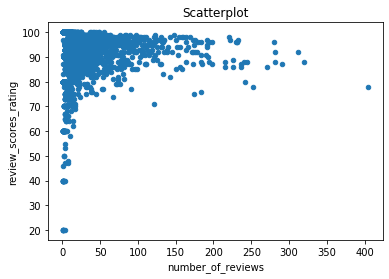

In [51]:
df_reduced.plot.scatter(x='number_of_reviews', y='review_scores_rating')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_reduced['review_scores_rating'].corr(df_reduced['number_of_reviews']))

The scatterplot shows an interesting pattern, however, the correlation coefficient not indicates a relation between the two measures. Obviously, the score rating mean of accommendations with a lower number of reviews has a higher variance in comparison to accommendations with many reviews. Thus, number of reviews is not taken into account for the further analysis.

### Is there a relation between amenities and rating?

In [57]:
# Consider only amenity variables
X = df_reduced[['24HourCheckin', 'airConditioning', 'breakfast', 'buzzerWirelessIntercom', 'cableTV', 
                'carbonMonoxideDetector', 'cats', 'dogs', 'doorman', 'dryer', 'elevatorInBuilding',
                'essentials', 'familyKidFriendly', 'fireExtinguisher', 'firstAidKit', 'freeParkingOnPremises',
                'freeParkingOnStreet', 'gym', 'hangers', 'hairDryer', 'heating', 'hotTub', 'indoorFireplace',
                'internet', 'iron', 'kitchen', 'laptopFriendlyWorkspace', 'lockOnBedroomDoor', 'otherPets',
                'paidParkingOffPremises', 'petsAllowed', 'petsLiveOnThisProperty', 'pool', 'safetyCard',
                'shampoo', 'smokeDetector', 'smokingAllowed', 'suitableForEvents', 'tV', 'washer',
                'wheelchairAccessible', 'wirelessInternet']]
y = df_reduced['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test =  r2_score(y_test, y_test_preds)

# Print r2 to see result
print('The R^2 value is:', r2_test)

The R^2 value is: 0.027724779654798914


In [69]:
for i in range(0, len(X.columns)):
    print(X.columns[i], ":", lm_model.coef_[i])

24HourCheckin : -0.340121047954179
airConditioning : 2.7317876062824884
breakfast : 1.3042176274479924
buzzerWirelessIntercom : -0.21038729129751121
cableTV : 0.4204153034957165
carbonMonoxideDetector : 0.6443822389804092
cats : -0.3133495178777601
dogs : 0.22930724138266922
doorman : 2.190397499365159
dryer : -1.5140851827550923
elevatorInBuilding : 0.9935627333454234
essentials : 1.58600568194622
familyKidFriendly : -0.9531499976138134
fireExtinguisher : 1.211068584706747
firstAidKit : 0.5802201174048289
freeParkingOnPremises : 0.6288871207631401
freeParkingOnStreet : -1.7908374457306395
gym : -2.4604631630812253
hangers : 0.4097147576601878
hairDryer : 0.26680120795864154
heating : 0.5456413467563991
hotTub : -1.8489787203631416
indoorFireplace : 0.8199489494794266
internet : -0.7031957480463981
iron : 0.013887505576841064
kitchen : -1.7216076334167185
laptopFriendlyWorkspace : 0.6485579584285656
lockOnBedroomDoor : -0.3371040656833359
otherPets : 0.6796447307018015
paidParkingOffPr

In [71]:
# Consider all variables
X = df_reduced[['property_type', 'room_type', 'bed_type', 'accommodates', 'price', '24HourCheckin', 'airConditioning', 'breakfast', 'buzzerWirelessIntercom', 'cableTV', 
                'carbonMonoxideDetector', 'cats', 'dogs', 'doorman', 'dryer', 'elevatorInBuilding',
                'essentials', 'familyKidFriendly', 'fireExtinguisher', 'firstAidKit', 'freeParkingOnPremises',
                'freeParkingOnStreet', 'gym', 'hangers', 'hairDryer', 'heating', 'hotTub', 'indoorFireplace',
                'internet', 'iron', 'kitchen', 'laptopFriendlyWorkspace', 'lockOnBedroomDoor', 'otherPets',
                'paidParkingOffPremises', 'petsAllowed', 'petsLiveOnThisProperty', 'pool', 'safetyCard',
                'shampoo', 'smokeDetector', 'smokingAllowed', 'suitableForEvents', 'tV', 'washer',
                'wheelchairAccessible', 'wirelessInternet']]
y = df_reduced['review_scores_rating']
property type, the room type, the accommodates, the bed type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test =  r2_score(y_test, y_test_preds)

# Print r2 to see result
print('The R^2 value is:', r2_test)

SyntaxError: invalid syntax (<ipython-input-71-143df628f083>, line 11)

In [72]:
df_reduced['property_type']

1          Apartment
2          Apartment
3              House
4              House
5        Condominium
6          Apartment
7              House
8        Condominium
9          Apartment
10             House
11             House
12       Condominium
13         Apartment
14             House
15         Apartment
16             House
17       Condominium
19             House
20             Villa
21             House
22         Apartment
23             House
24             House
25             House
26         Apartment
27             House
28         Apartment
29             House
30       Condominium
31         Apartment
            ...     
3517       Apartment
3518       Apartment
3520       Apartment
3522       Apartment
3523       Apartment
3524       Apartment
3526       Apartment
3528       Apartment
3529       Apartment
3531           House
3532       Apartment
3533           House
3534       Apartment
3541       Apartment
3545     Condominium
3548    Entire Floor
3551       Ap